GETTING DATA THROUGH TIINGO API

In [1]:
import pandas_datareader as data
key= "Fill in your key here"

In [2]:
df = data.get_data_tiingo('TSLA', api_key=key) #TSLA - TESLA 

SAVING DATA IN LOCAL MACHINE

In [3]:
import pandas as pd
df.to_csv('TSLA.csv')
df=pd.read_csv('TSLA.csv')

INSPECTING DATA

In [4]:
df.head(1)

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,TSLA,2016-10-06 00:00:00+00:00,201.0,204.2099,200.21,202.46,4703402,40.2,40.84198,40.042,40.492,23517010,0.0,1.0


In [5]:
df.tail(1)

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
1256,TSLA,2021-10-04 00:00:00+00:00,781.53,806.9699,776.12,796.5,30483341,781.53,806.9699,776.12,796.5,30483341,0.0,1.0


In [6]:
data=df['close']
data

0       201.00
1       196.61
2       200.95
3       200.10
4       201.51
         ...  
1252    777.56
1253    781.31
1254    775.48
1255    775.22
1256    781.53
Name: close, Length: 1257, dtype: float64

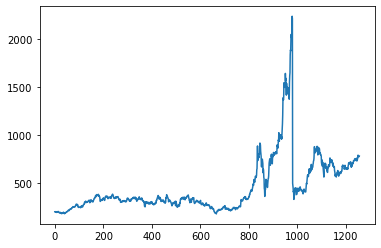

In [7]:
import matplotlib.pyplot as plt
plt.plot(data)

NORMALIZING THE DATA USING MINMAXSCALER

In [8]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
data=scaler.fit_transform(np.array(data).reshape(-1,1))

TRAIN & TEST SPLIT

In [9]:
train_size=int(len(data)*0.65) #Training size 65% of data
test_size=len(data)-train_size  #Testing size 35% of data
train_data,test_data=data[0:train_size,:],data[train_size:len(data),:1]
train_size,test_size

(817, 440)

In [10]:
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step),0]         #if timestep =100 , i=0, 0,1,2,3-----99  ---> Total(100) 
        dataX.append(a)
        dataY.append(dataset[i + time_step,0]) #timestep+1 as output
    return numpy.array(dataX), numpy.array(dataY)

In [11]:
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test,  ytest   = create_dataset(test_data, time_step)
print(X_test.shape), print(ytest.shape)


(339, 100)
(339,)


(None, None)

In [12]:
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
print(X_test.shape), print(ytest.shape)

(339, 100, 1)
(339,)


(None, None)

In [13]:
### Create the Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dropout(0.2))  
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='Nadam')

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 50)           10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [38]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=15,verbose=1)

Train on 716 samples, validate on 339 samples
Epoch 1/100
716/716 [==============================] - 4s 5ms/sample - loss: 5.6772e-05 - val_loss: 0.0042
Epoch 2/100
716/716 [==============================] - 3s 5ms/sample - loss: 5.1236e-05 - val_loss: 0.0042
Epoch 3/100
716/716 [==============================] - 3s 5ms/sample - loss: 4.1156e-05 - val_loss: 0.0044
Epoch 4/100
716/716 [==============================] - 3s 5ms/sample - loss: 4.7405e-05 - val_loss: 0.0036
Epoch 5/100
716/716 [==============================] - 3s 5ms/sample - loss: 4.2627e-05 - val_loss: 0.0045
Epoch 6/100
716/716 [==============================] - 3s 4ms/sample - loss: 3.9531e-05 - val_loss: 0.0035
Epoch 7/100
716/716 [==============================] - 3s 4ms/sample - loss: 3.9515e-05 - val_loss: 0.0028
Epoch 8/100
716/716 [==============================] - 3s 4ms/sample - loss: 3.5024e-05 - val_loss: 0.0031
Epoch 9/100
716/716 [==============================] - 3s 4ms/sample - loss: 3.7551e-05 - val_loss

In [16]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [17]:
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [18]:
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

310.1635345694963

In [19]:
### Test Data RMSE
math.sqrt(mean_squared_error(ytest,test_predict))

757.8892673966201

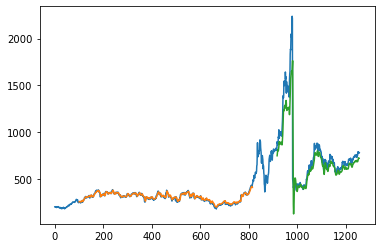

In [20]:
### Plotting 
# shift train predictions for plotting
look_back=100
trainPredictPlot = numpy.empty_like(data)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(data)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(data)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(data))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [21]:
len(test_data)

440

In [22]:
x_input=test_data[340:].reshape(1,-1)
temp_input=list(x_input)
temp_input=temp_input[0].tolist()
x_input.shape


(1, 100)

PREDCITION FOR  THE NEXT DAY 30 DAY

In [23]:
from numpy import array

Predict=[]
steps=100
i=0
while(i<30):
    
    if(len(temp_input)>steps):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        Predict.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        Predict.extend(yhat.tolist())
        i=i+1

[0.25870347]
101
1 day input [0.19942421 0.19315655 0.19366146 0.18666557 0.19798716 0.19512278
 0.20753187 0.20668227 0.21369272 0.21938265 0.21664935 0.21600851
 0.20689103 0.19121945 0.20394411 0.20689588 0.20614823 0.20381303
 0.20931847 0.20920681 0.21299362 0.20409461 0.20676966 0.21246444
 0.21572207 0.21451806 0.21591626 0.23186942 0.24315704 0.2392974
 0.24747789 0.2436134  0.24309878 0.24223461 0.24271039 0.23333074
 0.2260824  0.23004399 0.23205391 0.24601171 0.23768072 0.23032071
 0.22897106 0.22587364 0.22684461 0.23377739 0.231248   0.2283205
 0.22546583 0.23237919 0.22614551 0.22721359 0.24195788 0.24673994
 0.25764888 0.25768286 0.25825574 0.2600569  0.25251726 0.25963452
 0.25780423 0.25675072 0.26375632 0.26129004 0.24623989 0.23630679
 0.24760897 0.24007418 0.24337065 0.25601278 0.257076   0.25839167
 0.25351737 0.25874122 0.26796066 0.27029586 0.26950451 0.26867918
 0.26925206 0.27864626 0.27910748 0.27958811 0.27056288 0.27383021
 0.27455359 0.28005904 0.2806222  0

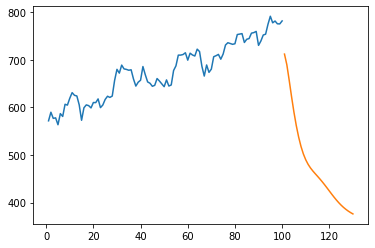

In [24]:
day_new=np.arange(1,101)
day_pred=np.arange(101,131)
import matplotlib.pyplot as plt
plt.plot(day_new,scaler.inverse_transform(data[1157:]))
plt.plot(day_pred,scaler.inverse_transform(Predict))

VISUALIZATION

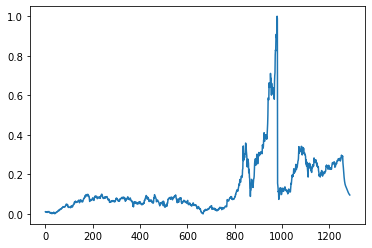

In [25]:
visualize=data.tolist()
visualize.extend(Predict)
plt.plot(visualize)

FOCUS ON 30 DAY PREDICTION OF THE STOCK

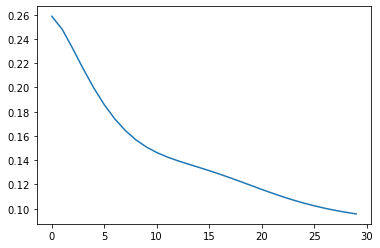

In [26]:
plt.plot(visualize[1257:])

SAVING THE PREDICTION AS CSV TO VISUALIZE IN POWERBI

In [35]:
save = pd.DataFrame(scaler.inverse_transform(Predict),columns=["predictions"])

In [36]:
save.head()

,predictions
0,711.842234
1,689.442768
2,656.754724
3,622.323251
4,590.102602


In [37]:
save.to_csv('Pred.csv')